# Colab Authentication

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import os

os.chdir('/gdrive/My Drive/work_space/11_duygu_tanima')

In [3]:
!ls 

data  Duygu_Tanima.ipynb  emotion_recognition_v2.ipynb	images


# Setup

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, MaxPool2D
from keras.layers import Flatten, Dropout, BatchNormalization, Activation

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Data Preprocessing

Dataset: [KAGGLE- Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

In [5]:
root = '/gdrive/My Drive/work_space/11_duygu_tanima/'

dataset = pd.read_csv(root + 'data/fer2013/fer2013.csv', names=["emotion", "usage", "pixels"])
dataset.shape

(35888, 3)

In [6]:
dataset.drop(0, axis=0, inplace=True)

In [7]:
dataset.head()

,emotion,usage,pixels
1,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
2,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
3,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
4,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
5,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
dataset["usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


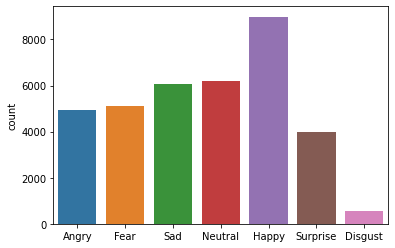

In [9]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

emotions2 = [emotions[int(i)] for i in dataset["emotion"].values]
sns.countplot(emotions2)

## Train Data

In [10]:
train_data = dataset[dataset.usage == "Training"]

In [11]:
train_pixels = train_data.pixels.str.split(" ").tolist() 
train_images = np.array(train_pixels).astype("float32")

print(train_images.shape)
print(train_images)

(28709, 2304)
[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]


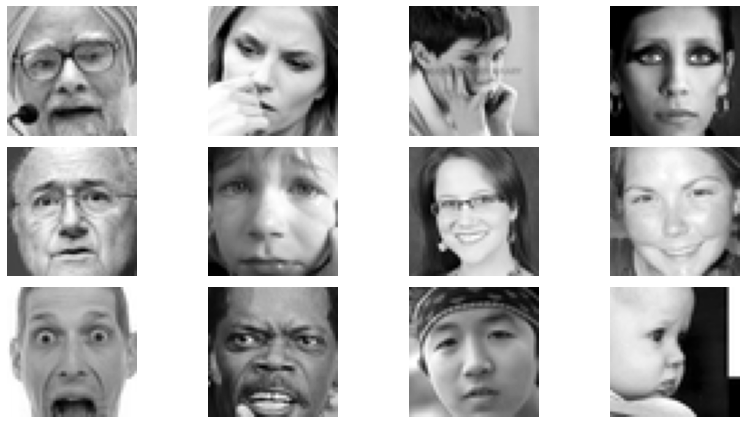

In [12]:
# Virtualize train data
plt.figure(0, figsize=(12,6))

for i in range(1,13):
  plt.subplot(3, 4, i)
  image = train_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')
  plt.axis('off')

plt.tight_layout()
plt.show()

## Validation Data

In [13]:
val_data = dataset[dataset.usage == "PublicTest"] 

In [14]:
val_pixels = val_data.pixels.str.split(" ").tolist() 
val_images = np.array(val_pixels).astype("float32")

print(val_images.shape)
print(val_images)

(3589, 2304)
[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]


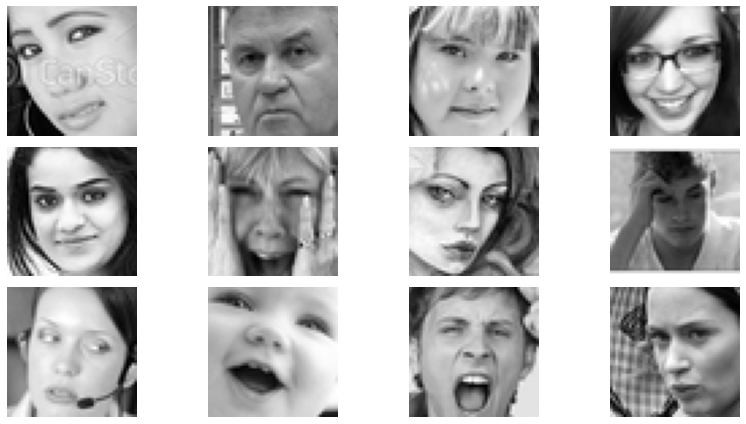

In [15]:
#Virtualize validation data
plt.figure(0, figsize=(12,6))

for i in range(1,13):
  plt.subplot(3, 4, i)
  image = val_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')
  plt.axis('off')

plt.tight_layout()
plt.show()

## Scale images

In [16]:
X_train = train_images.reshape(-1, 48, 48, 1).astype("float32") / 255
X_val = val_images.reshape(-1, 48, 48, 1).astype("float32") / 255

print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)

X_train shape (28709, 48, 48, 1)
X_val shape (3589, 48, 48, 1)


## Encode label columns

In [17]:
y_train = train_data["emotion"].values
y_val = val_data["emotion"].values

print("y_train shape", y_train.shape)
print("y_test shape", y_val.shape)

y_train shape (28709,)
y_test shape (3589,)


In [18]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

print("y_train shape", y_train.shape)
print("y_val shape", y_val.shape)

y_train shape (28709, 7)
y_val shape (3589, 7)


# Create Model



In [47]:
model = Sequential()

model.add(Conv2D(32, 3, padding="same", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))

model.add(Dense(7, activation="softmax"))


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

# Train Model

In [48]:
BATCH_SIZE = 128
EPOCHS = 16

checkpointer = ModelCheckpoint(filepath=root + 'data/face_model_2.h5', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [49]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [50]:
hist = model.fit(X_train, y_train,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[checkpointer, early_stop],
                 validation_data=(X_val, y_val))           

Epoch 1/16
224/225 [============================>.] - ETA: 0s - loss: 1.6442 - accuracy: 0.3568
Epoch 00001: val_loss improved from inf to 1.80773, saving model to /gdrive/My Drive/work_space/11_duygu_tanima/data/face_model_2.h5
225/225 [==============================] - 8s 31ms/step - loss: 1.6440 - accuracy: 0.3570 - val_loss: 1.8077 - val_accuracy: 0.2232
Epoch 2/16
224/225 [============================>.] - ETA: 0s - loss: 1.3818 - accuracy: 0.4667
Epoch 00002: val_loss improved from 1.80773 to 1.50275, saving model to /gdrive/My Drive/work_space/11_duygu_tanima/data/face_model_2.h5
225/225 [==============================] - 6s 29ms/step - loss: 1.3816 - accuracy: 0.4668 - val_loss: 1.5027 - val_accuracy: 0.3968
Epoch 3/16
223/225 [============================>.] - ETA: 0s - loss: 1.2660 - accuracy: 0.5135
Epoch 00003: val_loss improved from 1.50275 to 1.31671, saving model to /gdrive/My Drive/work_space/11_duygu_tanima/data/face_model_2.h5
225/225 [==============================] 

# Evaluate Model

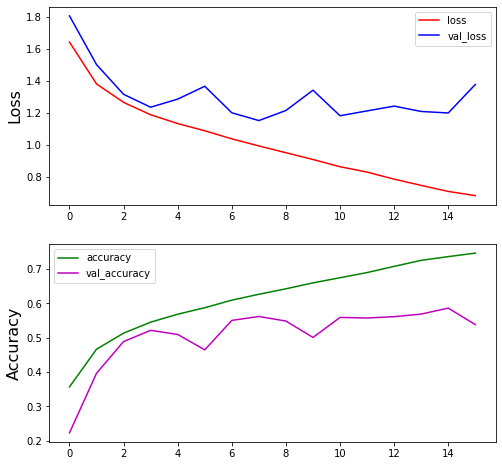

In [51]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='loss')
plt.plot(hist.history['val_loss'], color ='b', label='val_loss')
plt.legend()


plt.subplot(2, 1, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='val_accuracy')
plt.legend()

plt.show()


## Save model to json

In [53]:
model_json = model.to_json()
with open(root + 'data/face_model_2.json', 'w') as json_file:
  json_file.write(model_json)

# Private Test 

In [54]:
test_data = dataset[["emotion", "pixels"]][dataset["usage"] == "PrivateTest"]
test_data["pixels"] = test_data["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test_data.head()

,emotion,pixels
32299,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32300,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32301,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32302,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32303,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [55]:
X_test = np.vstack(test_data["pixels"].values)
y_test = test_data["emotion"].values

In [56]:
X_test = X_test.reshape(-1, 48, 48, 1).astype("float32") / 255

print("X_test shape", X_test.shape)

X_test shape (3589, 48, 48, 1)


In [57]:
y_test = tf.keras.utils.to_categorical(y_test)

print("y_test shape", y_test.shape)

y_test shape (3589, 7)


In [58]:
score = model.evaluate(X_test, y_test, verbose=0)
print("private test score:", score)

private test score: [1.3485959768295288, 0.5321816802024841]


# Predictions

In [59]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [60]:
model_best = load_model(root + 'data/face_model_2.h5')


In [61]:
os.chdir('/gdrive/My Drive/work_space/11_duygu_tanima/images')

In [62]:
!ls

brando.png  hababam.jpg        javierbardem.jpg  robertdeniro.jpg
emojis	    javierbardem2.jpg  kemal_sunal2.jpg


In [63]:
image_path = root + "images/brando.png"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 2.1263161e-22, 0.0000000e+00]], dtype=float32)

### Virtualize with emojis

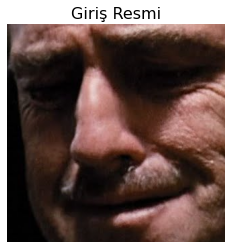

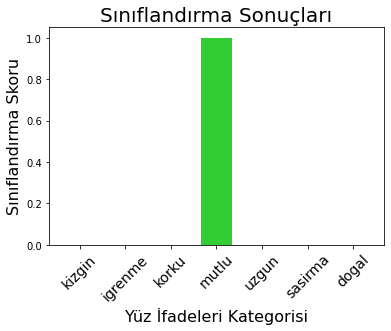

Sınıflandırma sonucu en yüksek oranla: mutlu


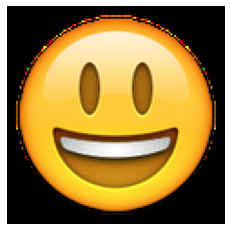

In [64]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1 + 0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

# en yüksek skorlu duyguya karşılık emoji çizdirelim

emojis_img = image.load_img(root + 'images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()
